In [1]:
import glob
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model, Parameters, report_fit,  minimize
import sys
from scipy.interpolate import interp1d
fill_val = 'extrapolate'
from csv import writer
from astropy.table import Table
import os

In [2]:
def read_HERMES(infile):
    #print("%s: Input file is a HERMES file." % infile)
    header = fits.getheader(infile)

    bjd = header['MJD-OBS']
    # for files with standard wavelegth array
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt

    # for files that are given in logarithmic wl array
    if (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    return wave, flux, bjd


def read_line_list(filename):
    line_centers = []
    line_widths = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  #removing whitespaces
            if not line:
                continue  #skipping empty lines
            parts = line.split()
            center = float(parts[0])
            if len(parts) > 1:
                width = float(parts[1])
            else:
                width = 10.0  #default
            line_centers.append(center)
            line_widths.append(width)

    return line_centers, line_widths

In [3]:
def bestline(rv, line):
  return line - rv*line/(3*10**5)

def gauss(x,a,rv,sigma, gamma, line):
  return a*np.exp(-(x-bestline(rv, line))**2/(2*sigma**2)) + gamma

In [4]:
def get_all_spectra(folder_path):
    file_paths = glob.glob(os.path.join(folder_path, '*.fits'))
    spectra = [read_HERMES(file) for file in file_paths]
    waves = [s[0] for s in spectra]  # List of wavelength arrays for each epoch
    fluxes = [s[1] for s in spectra]  # List of flux arrays for each epoch
    return waves, fluxes , len(file_paths)

def generate_data(waves, fluxes, line_centers, line_widths, wavelength_slices):
    wave_slices = []
    flux_slices = []
    
    for wave, flux in zip(waves, fluxes):
        interp_func = interp1d(wave, flux, kind='linear')
        for center, width in zip(line_centers, line_widths):
            new_wave = np.linspace(center - width, center + width, wavelength_slices)
            new_flux = interp_func(new_wave)
            wave_slices.append(new_wave)
            flux_slices.append(new_flux)
    
    return np.concatenate(wave_slices), np.concatenate(flux_slices)

In [5]:
# change this to generate gaussian depending on the RVs

def generate_gauss(params, line_centers, line_widths, wavelength_slices, num_epochs):
    model_slices = []
    for epoch in range(num_epochs):
        for i, (center, width) in enumerate(zip(line_centers, line_widths)):
            wave = np.linspace(center - width, center + width, wavelength_slices)
            model = gauss(wave, params[f'a{i}'], params[f'rv{epoch}'], params[f'sigma{i}'], params[f'gamma{i}'], center)
            model_slices.append(model)
    return np.concatenate(model_slices)

In [6]:


def objective(params, waves, fluxes, line_centers, line_widths, wavelength_slices, num_epochs):
    _ , flux_data = generate_data(waves, fluxes, line_centers, line_widths, wavelength_slices)
    model = generate_gauss(params, line_centers, line_widths, wavelength_slices, num_epochs)
    return flux_data - model

def fit_lines(waves, fluxes, line_centers, line_widths, num_epochs, wavelength_slices=1000):
    params = Parameters()
   
    for i, (center, width) in enumerate(zip(line_centers, line_widths)):
        params.add(f'a{i}', value=-1)
        params.add(f'sigma{i}', value=width) 
        params.add(f'gamma{i}', value=1) 

    for epoch in range(num_epochs):
        params.add(f'rv{epoch}', value=20) 
    
    result = minimize(objective, params=params, args=(waves, fluxes, line_centers, line_widths, wavelength_slices, num_epochs))
    return result

In [48]:
line_centers, line_widths = read_line_list('line_list.txt')
waves, fluxes, num_epochs =  get_all_spectra('/home/c4011027/PhD_stuff/be_paper/hermes_data/25_ori/')
result = fit_lines(waves, fluxes, line_centers, line_widths, num_epochs)

In [49]:
result

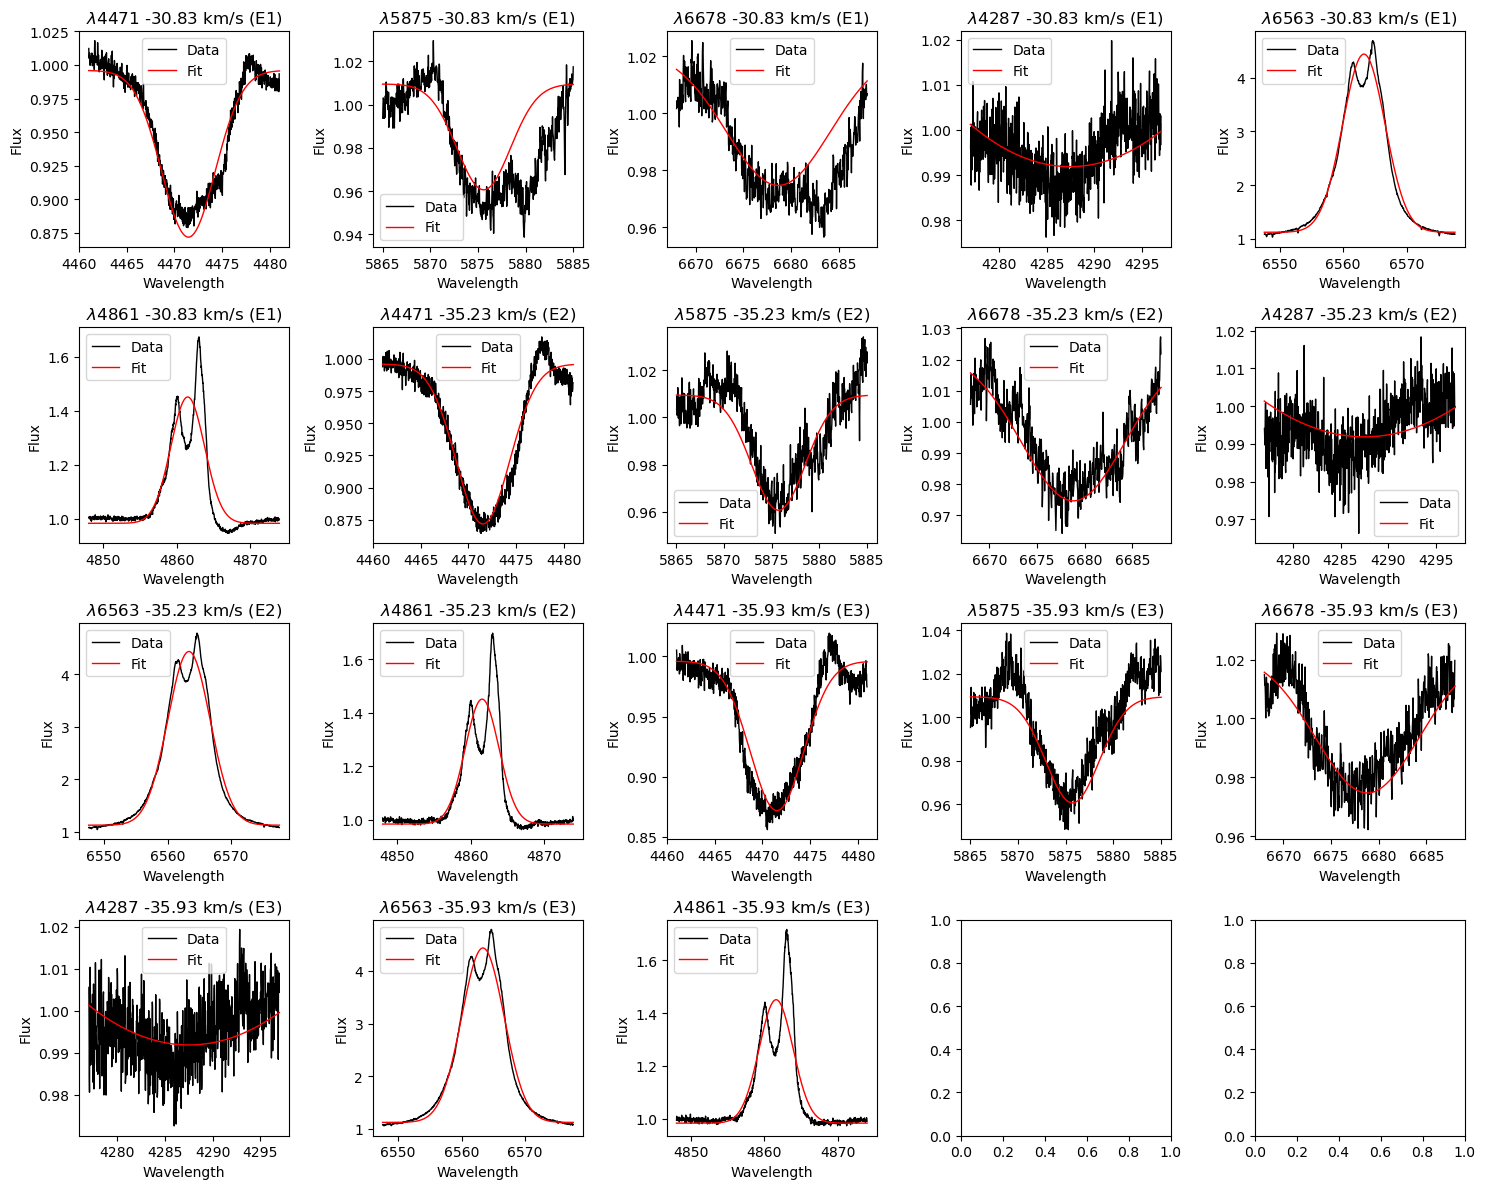

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fits_for_epochs(wave_slices_all_epochs, flux_slices_all_epochs, line_centers, line_widths, fit_results, num_epochs):
    num_lines = len(line_centers)
    num_subplots = num_lines * num_epochs

    # Determine grid size (square or nearly square)
    ncols = int(np.ceil(np.sqrt(num_subplots)))
    nrows = int(np.ceil(num_subplots / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for epoch in range(num_epochs):
        rv = fit_results.params[f'rv{epoch}'].value  # RV for the current epoch
        
        for i, (center, width) in enumerate(zip(line_centers, line_widths)):
            ax = axes[epoch * num_lines + i]
            
            # Extract the data slices for the current epoch and line
            wave = wave_slices_all_epochs[epoch]
            flux = flux_slices_all_epochs[epoch]
            mask = (wave >= center - width) & (wave <= center + width)
            wave = wave[mask]
            flux = flux[mask]
            
            # Generate the fitted Gaussian for the current line and epoch
            a = fit_results.params[f'a{i}'].value
            sigma = fit_results.params[f'sigma{i}'].value
            gamma = fit_results.params[f'gamma{i}'].value
            
            # Create the fitted Gaussian model
            fit_wave = np.linspace(center - width, center + width, len(wave))
            fit_flux = gauss(fit_wave, a, rv, sigma, gamma, center)
            
            # Plot the data slice
            ax.plot(wave, flux, label='Data', color='black', lw=1)
            
            # Overlay the fit
            ax.plot(fit_wave, fit_flux, label='Fit', color='red', lw=1)
            
            ax.set_title(f'$\lambda${center:.0f} {rv:.2f} km/s (E{epoch+1})')
            ax.set_xlabel('Wavelength')
            ax.set_ylabel('Flux')
            ax.legend()
    
    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming `wave_slices_all_epochs` and `flux_slices_all_epochs` are lists of wave and flux slices for each epoch
# You would generate these using your `generate_data_slices` function for each epoch.
line_centers, line_widths = read_line_list('line_list.txt')
waves, fluxes, num_epochs =  get_all_spectra('/home/c4011027/PhD_stuff/be_paper/hermes_data/25_ori/')
plot_fits_for_epochs(waves, fluxes, line_centers, line_widths, result , num_epochs)


In [ ]:
report_fit(result)